In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Introduction

Are you an enthusiastic gamer who wants to know which **great games** your collection lacks?

Or maybe you're a gaming platform **manager** who wants to discover which classic titles were loved by players and could **benefit** your company through remastering?

Or perhaps you simply want to understand the **trends** in the game market over the last three decades?

This notebook will try to answer these questions, through a detailed analysis.

## EDA

### Import data

In [190]:
sales = pd.read_csv('data/game_sales_data.csv')

In [191]:
sales.head()

,Name,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Year
0,Wii Sports,Wii,Nintendo,Nintendo EAD,7.7,8.0,82.90,2006
1,Super Mario Bros.,NES,Nintendo,Nintendo EAD,10.0,8.2,40.24,1985
2,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,8.0,7.5,40.00,2012
3,Mario Kart Wii,Wii,Nintendo,Nintendo EAD,8.2,9.1,37.32,2008
4,PLAYERUNKNOWN'S BATTLEGROUNDS,PC,PUBG Corporation,PUBG Corporation,8.6,4.7,36.60,2017


### Data overview

Are there any duplicates? If so, remove them. I'm using a subset of variables, because a duplicated game may happen to have different reviews/total_shipping for some reason. In such case it won't get detected if all variables are used as a criterion:

In [196]:
print(f"Number of duplicates in sales: {sales.duplicated(subset=['Name','Platform','Developer','Year']).sum()}")
sales.drop_duplicates(inplace=True,subset=['Name','Platform','Developer','Year'])

Number of duplicates in sales: 36


Let's also convert year to Datetime:

In [220]:
sales['Year'] = pd.to_datetime(sales['Year'], format='%Y')

In [221]:
sales.describe()

,Critic_Score,User_Score,Total_Shipped
count,9941.000000,2212.000000,19564.000000
mean,7.033618,6.992586,0.551600
std,1.559922,1.518455,1.672831
min,0.800000,1.000000,0.010000
25%,6.100000,6.300000,0.050000
50%,7.300000,7.200000,0.160000
75%,8.200000,8.000000,0.460000
max,10.000000,10.000000,82.900000


Both user and critics scores range from about 1 to 10 points. The minimum for the critics score is 0.8. Is this an error? Let's examine:

In [226]:
sales[sales['Critic_Score'] == sales['Critic_Score'].min()]

,Name,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Year
19163,Action Girlz Racing,Wii,Conspiracy Entertainment,Data Design Interactive,0.8,NaN,0.01,2008-01-01


After a quick glance at Metacritc site (from where the scores were collected) I noticed, that critics can review items using 100 point scale, while users can post reviews using 10 point scale, which additionally allows for decimal scores. Critic scores might have been rescaled to match user score scale. This does not affect the analysis and the results, so let's just leave it as it is.

In [224]:
sales.describe(include=['O'])

,Name,Platform,Publisher,Developer
count,19564,19564,19564,19562
unique,13612,37,1012,3054
top,FIFA 14,DS,Activision,Unknown
freq,9,2249,1024,489


In [199]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19564 entries, 0 to 19599
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           19564 non-null  object 
 1   Platform       19564 non-null  object 
 2   Publisher      19564 non-null  object 
 3   Developer      19562 non-null  object 
 4   Critic_Score   9941 non-null   float64
 5   User_Score     2212 non-null   float64
 6   Total_Shipped  19564 non-null  float64
 7   Year           19564 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 1.3+ MB


Percentages of missing values:

In [200]:
na_df = sales.isna().sum().to_frame().rename({0:'null_count'},axis=1)
na_df['%'] = (na_df['null_count'] / na_df['null_count'].sum() * 100).round(1)
na_df

,null_count,%
Name,0,0.0
Platform,0,0.0
Publisher,0,0.0
Developer,2,0.0
Critic_Score,9623,35.7
User_Score,17352,64.3
Total_Shipped,0,0.0
Year,0,0.0


Number of unique values for categorical variables:

In [227]:
sales.select_dtypes(include='object').nunique()

Name         13612
Platform        37
Publisher     1012
Developer     3054
dtype: int64

There are 13612 games in total, released for 37 platforms by 1012 different publishers and created by 3054 developers, who also happen to be publishers in some cases. 

### Univariate and bivariate analysis

#### Categorical variables

<AxesSubplot: xlabel='count', ylabel='Platform'>

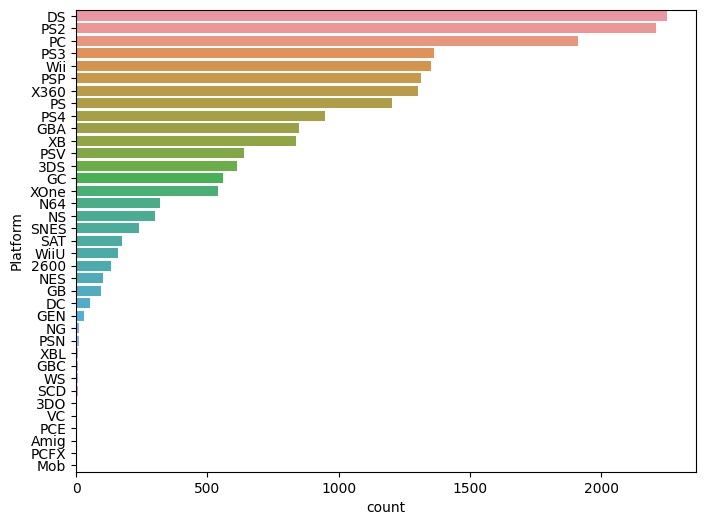

In [242]:
plt.figure(figsize=(8,6))
sns.countplot(data=sales,y='Platform',order=sales['Platform'].value_counts().index)

Over the last couple of decades, majority of games were released for consoles (with DS - Double Screen, PS2, PS3, Wii in the first places) and for PC as the third platform according to popularity.

#### Numeric variables

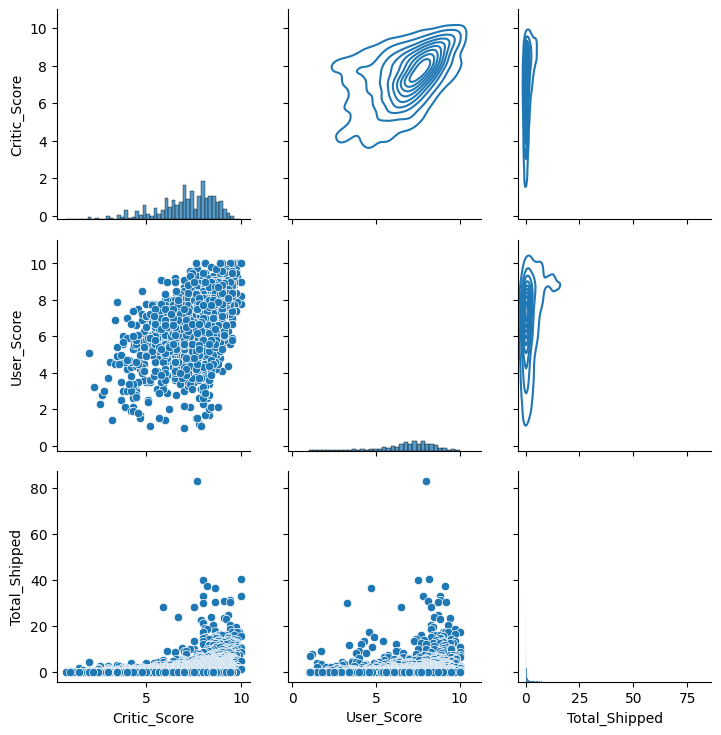

In [297]:
g = sns.PairGrid(data=sales.select_dtypes('number'))
g.map_upper(sns.kdeplot)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)

User scores are positively correlated with critic scores, which could have been anticipated. Games with critic score ~ 5-6 and less were sold in rather small quantities, while sales performance of these with higher ratings is visibly better.

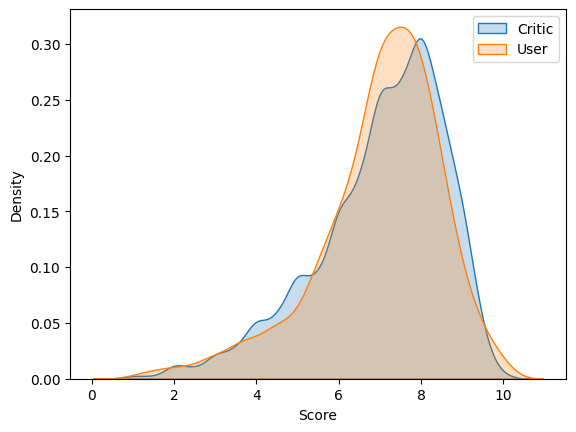

In [263]:
fig, ax = plt.subplots()
sns.kdeplot(sales,x='Critic_Score',fill=True,label='Critic',ax=ax)
sns.kdeplot(sales,x='User_Score',fill=True,label='User',ax=ax)
ax.set_xlabel('Score')
ax.legend()

The distributions of critic and users ratings are quite similar. Distribution of user scores displays a peak somewhat earlier than the distribution of critic scores (remember however, that there were almost twice as much null values in user counts, so the sample is effectively smaller). Both distributions are left-skewed.

Text(0.5, 0, 'Total units sold (mln copies)')

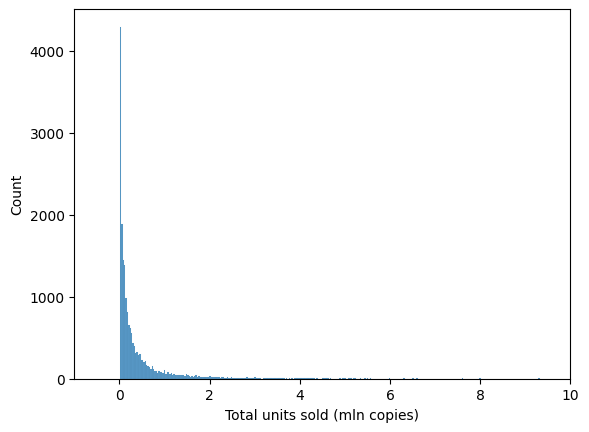

In [298]:
ax = sns.histplot(sales,x='Total_Shipped')
ax.set_xlim([-1,10])
ax.set_xlabel('Total units sold (mln copies)')

The vast majority of games were sold in small to moderate quantities. There are a number of outliers, which probably represent the greatest hits of all time.

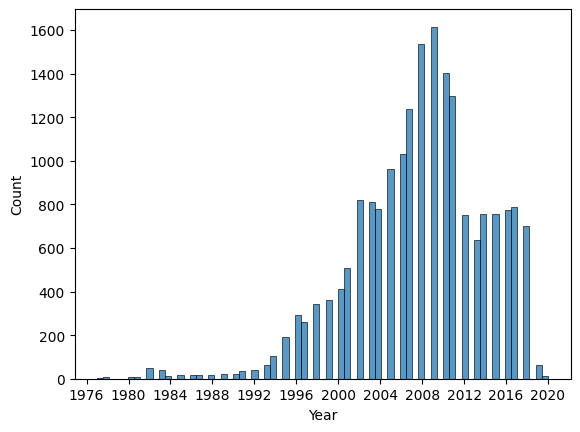

In [281]:
from matplotlib.ticker import MultipleLocator
ax = sns.histplot(x=sales['Year'].dt.year)
ax.xaxis.set_major_locator(MultipleLocator(4))

In [287]:
print(f"Min year: {sales['Year'].min().year}, Max year: {sales['Year'].max().year}")

Min year: 1977, Max year: 2020


The dataset includes games from 1977 to 2020, with the majority of the games originating between 2000 and 2016.

How many games were released each year (or at least how many were collected in the dataset)?

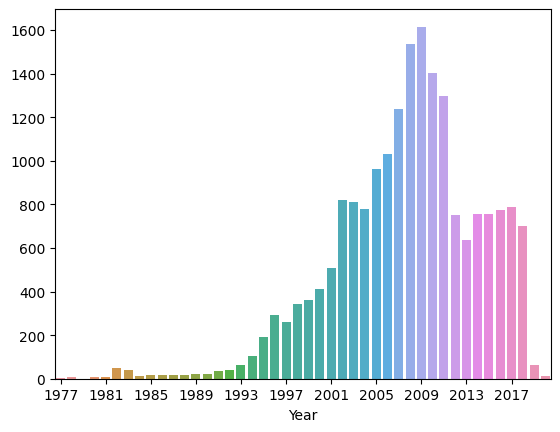

In [315]:
n_games_per_year = sales.groupby(sales['Year'].dt.year)['Name'].count()
sns.barplot(x=n_games_per_year.index, y=n_games_per_year.values)
plt.gca().xaxis.set_major_locator(MultipleLocator(4))

## Analysis

### Case I: General trends in the gaming market

#### How have the total sales in global gaming market changed over the years?

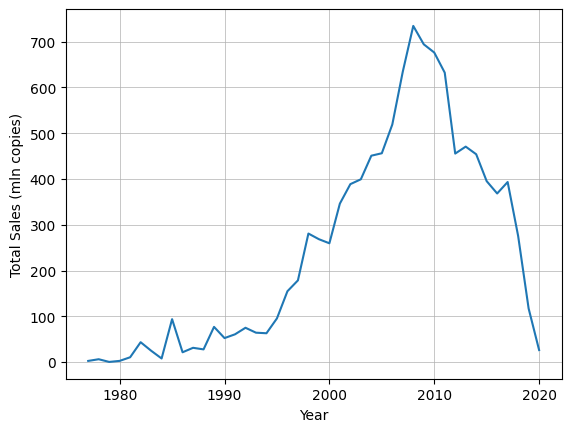

In [308]:
sales_yearly_trend = sales.groupby(sales['Year'].dt.year)['Total_Shipped'].sum()
sns.(sales_yearly_trend)
plt.ylabel('Total Sales (mln copies)')
plt.grid(lw=0.5)

Although 2020 looks like a disaster for the industry, let's remember, that the dataset contains only several games for this time period. Generally, a peak in sales around 2008-2009 can be observed with a subsequent decline in the sales.

Let's also differentiate the trend between various platforms:

In [324]:
sales_yearly_trend_platforms = sales.groupby([sales['Year'].dt.year,'Platform'])['Total_Shipped'].agg({'sum','count'}).reset_index()

Now we can compare different segments of the gaming industry. Let's examine how, for instance, the game sales for different generations of Playstation have changed over the years:

In [327]:
sales_yearly_ps_generations = sales_yearly_trend_platforms[sales_yearly_trend_platforms['Platform'].isin(['PS','PS2','PS3','PS4'])]

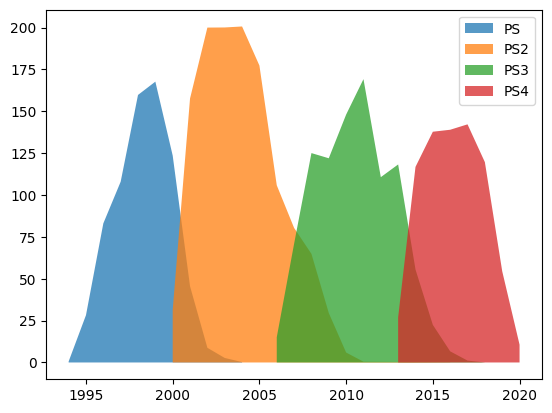

In [336]:
for gen in ['PS','PS2','PS3','PS4']:
    mask = sales_yearly_ps_generations['Platform'] == gen
    plt.fill_between(sales_yearly_ps_generations[mask]['Year'],
                     sales_yearly_ps_generations[mask]['sum'],
                     alpha=0.75,
                     label=gen)
plt.legend()

"Four mountain kings as seen chronologically, grandfather to son". 


OK, jokes aside - what we can learn from this plot is that, for instance, the golden time for PS2 platform began around 2001 and lasted until 2005-2006, when PS3 started to replace it.

#### Based on critic scores, are games getting worse or better?

Let's investigate two things:
- the number of games with the average critic score (averaged across different platforms) > 8.0 points
- how the average critic score have changed over the years, with particular focus on PC games

Text(0, 0.5, 'Number of games')

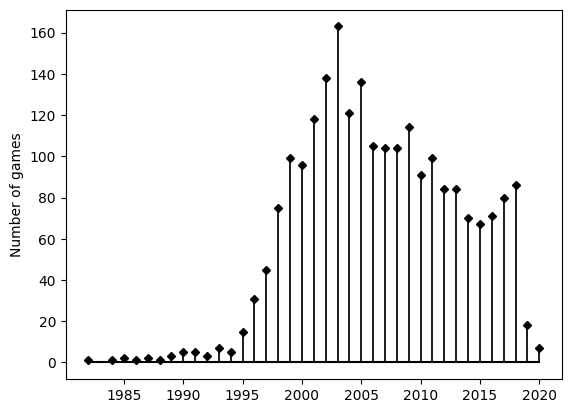

In [417]:
# Calculate the mean with respect to the Platform
n_great_games_per_year = sales.groupby([sales['Year'].dt.year,'Name'])['Critic_Score'].mean().dropna().reset_index()
# Calculate the mean with respect to the Year
n_great_games_per_year = n_great_games_per_year[n_great_games_per_year['Critic_Score'] >= 8.0].groupby('Year')['Name'].count() 
markerline, stemline, baseline, = plt.stem(n_great_games.index, n_great_games.values,linefmt='k-', markerfmt='kD', basefmt='k', orientation='vertical')
plt.setp(stemline, linewidth = 1.25)
plt.setp(markerline, markersize = 4)
plt.ylabel('Number of games')

It seems, that the number of games considered by critics to be great has been decreasing since 2003. The plot also shows, that prior to 1995 there were seemingly only a few good games per year, but again - there is a small number of games released in these years in the dataset in general, so actually the actual fraction of great games might be quite high! Let's check it out:

In [428]:
n_great_games_per_year_joined = pd.merge(left=n_great_games_per_year.reset_index().rename({'Name':'count'},axis=1),
                                         right=n_games_per_year.reset_index().rename({'Name':'count'},axis=1),
                                         on='Year',
                                         how='inner',
                                         suffixes=('_great','_total'))
n_great_games_per_year_joined['%Total'] = (n_great_games_per_year_joined['count_great'] / n_great_games_per_year_joined['count_total'] * 100).round(1)

In [438]:
n_great_games_per_year_joined[(n_great_games_per_year_joined['Year'].between(1977, 1995)) | (n_great_games_per_year_joined['Year'].between(2000, 2010))]

,Year,count_great,count_total,%Total
0,1982,1,47,2.1
1,1984,1,12,8.3
2,1985,2,15,13.3
3,1986,1,18,5.6
4,1987,2,16,12.5
5,1988,1,17,5.9
6,1989,3,20,15.0
7,1990,5,21,23.8
8,1991,5,34,14.7
9,1992,3,40,7.5


Well, maybe the hypothesis wasn't so accurate as I thought - the dataset contains only a few games released between 1977 and 1995, making it challenging to draw confident conclusions about this period. Additionally, games released before 1982 are absent from this summary, suggesting a lack of available reviews for those titles.  On the other hand, in 2001 the percentage of games considered to be "great" by our criteria is quite high (23.2%), taking the total number of games released this year (508) into account.

Actually, the critic score in the dataset is likely an average of scores published by various critics on Metacritic. The information about the number of original reviews would be valuable and could improve conclusions, but unfortunately it's not available. 

How about average critic scores for PC games?

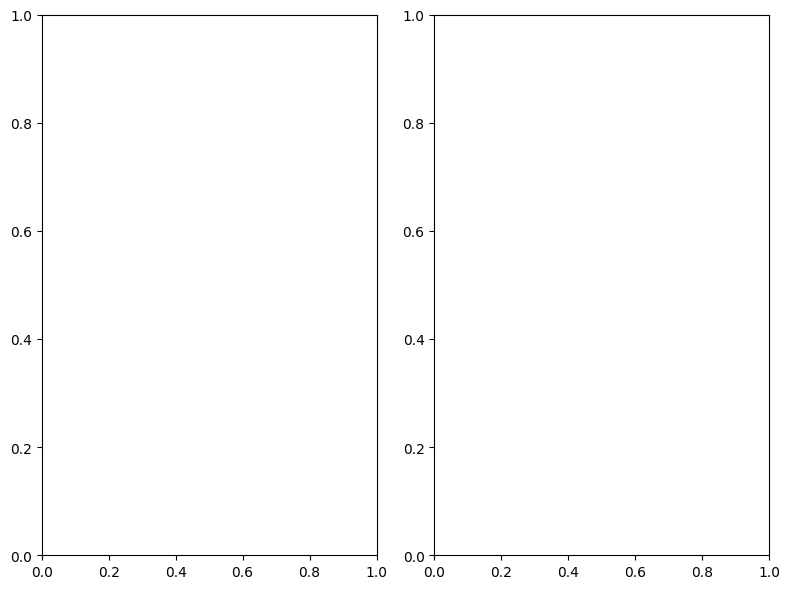

In [474]:
pc_game_sales = sales[sales['Platform'] == 'PC']
pc_game_sales = pc_game_sales.groupby(pc_game_sales['Year'].dt.year)['Critic_Score'].agg(['mean','count'])
fig, ax = plt.subplots(ncols=2,figsize=(8,6))
# sns.lineplot(pc_game_sales.iloc[:-1]['mean'],ax=ax[0])
# ax[0].set_ylabel('Score')
# ax[0].grid(lw=0.5)

plt.tight_layout()

### How do average sales vary based on critic score?

Let's divide critic scores into three groups:
- low: critic score < 5.5
- medium: 5.5 <= critic score <= 8.5, 
- high: critic score > 8.5

And analyze the average sales in each group.

#### Finally, what are the 3 best-selling and 3 best-rated games of all times?

#### Conclusions

### Case II: Which games are worth rediscovering?

### Case III: Which classic titles could bring more players to a gaming platform?

Analyze, how a specific company does compared to its competitors. Choose a company and 5 biggest competitors.